# Housekeeping (Importing libraries, loading datasets)

In [1]:
from utility import random_number_generator as rng

import pandas as pd
import numpy as np
from datetime import datetime
import time

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.graph_objects as go
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import qmc
from scipy.stats import norm

### SOFR Data Work

In [2]:
# secured overnight financing rate, sourced from the st. louis fred
sofr = pd.read_csv('data/FRED_SOFR.csv', parse_dates=['DATE'], index_col='DATE')

In [3]:
sofr.head()

,SOFR
DATE,
2018-04-03,1.83
2018-04-04,1.74
2018-04-05,1.75
2018-04-06,1.75
2018-04-09,1.75


In [4]:
print(sofr.info())
print(sofr.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1719 entries, 2018-04-03 to 2024-11-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   SOFR    1719 non-null   object
dtypes: object(1)
memory usage: 26.9+ KB
None
            SOFR
DATE            
2018-04-03  1.83
2018-04-04  1.74
2018-04-05  1.75
2018-04-06  1.75
2018-04-09  1.75


### Preprocessing SOFR

In [5]:
sofr['SOFR'] = pd.to_numeric(sofr['SOFR'], errors='coerce')  # Convert to numeric, set invalid entries to NaN
sofr.dropna(subset=['SOFR'], inplace=True)
sofr['Rate'] = sofr['SOFR'] / 100

In [6]:
print(sofr.head())

            SOFR    Rate
DATE                    
2018-04-03  1.83  0.0183
2018-04-04  1.74  0.0174
2018-04-05  1.75  0.0175
2018-04-06  1.75  0.0175
2018-04-09  1.75  0.0175


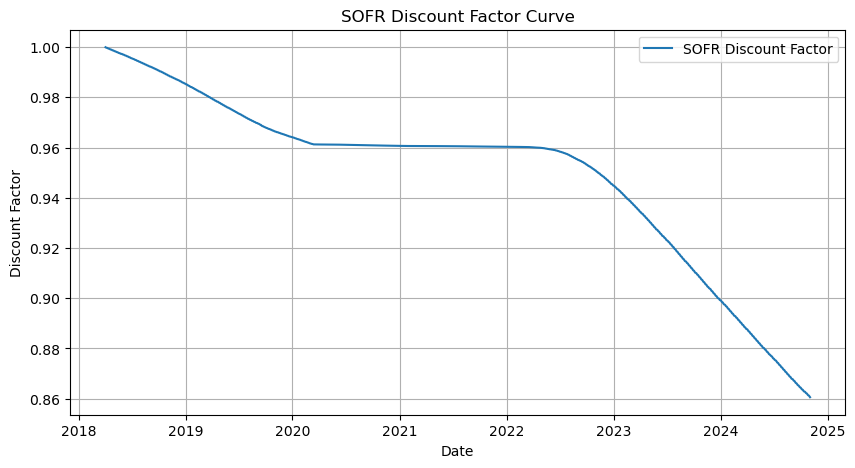

In [7]:
dt = 1 / 252
sofr['Rate'] = sofr['SOFR'] / 100
sofr['Discount_Factor'] = np.exp(-np.cumsum(sofr['Rate'] * dt))

plt.figure(figsize=(10, 5))
plt.plot(sofr.index, sofr['Discount_Factor'], label="SOFR Discount Factor")
plt.title("SOFR Discount Factor Curve")
plt.xlabel("Date")
plt.ylabel("Discount Factor")
plt.legend()
plt.grid()
plt.show()

### Market Yield Data Work

In [8]:
dgs1 = pd.read_csv('data/DGS1.csv', parse_dates=['DATE'], index_col='DATE')
dgs2 = pd.read_csv('data/DGS2.csv', parse_dates=['DATE'], index_col='DATE')
dgs5 = pd.read_csv('data/DGS5.csv', parse_dates=['DATE'], index_col='DATE')
dgs10 = pd.read_csv('data/DGS10.csv', parse_dates=['DATE'], index_col='DATE')
dgs30 = pd.read_csv('data/DGS30.csv', parse_dates=['DATE'], index_col='DATE')

yc = pd.concat([dgs1.rename(columns={'DGS1': '1Y'}),
                              dgs2.rename(columns={'DGS2': '2Y'}),
                              dgs5.rename(columns={'DGS5': '5Y'}),
                              dgs10.rename(columns={'DGS10': '10Y'}),
                              dgs30.rename(columns={'DGS30': '30Y'})], axis=1)

# I. Exploratory Data Analysis

In [9]:
print("\nMissing values in SOFR Data:", sofr.isna().sum())
print("Missing values in Yield Curve Data:", yc.isna().sum())


Missing values in SOFR Data: SOFR               0
Rate               0
Discount_Factor    0
dtype: int64
Missing values in Yield Curve Data: 1Y        0
2Y     3760
5Y        0
10Y       0
30Y    3945
dtype: int64


In [10]:
print("\nSOFR Summary Statistics:")
print(sofr.describe())


SOFR Summary Statistics:
              SOFR         Rate  Discount_Factor
count  1647.000000  1647.000000      1647.000000
mean      2.297535     0.022975         0.949605
std       2.014423     0.020144         0.033830
min       0.010000     0.000100         0.860570
25%       0.090000     0.000900         0.936837
50%       1.950000     0.019500         0.960496
75%       4.550000     0.045500         0.965557
max       5.400000     0.054000         0.999927


In [11]:
print("\nYield Curve Summary Statistics:")
print(yc.describe())


Yield Curve Summary Statistics:
           1Y     2Y     5Y    10Y    30Y
count   16393  12633  16393  16393  12448
unique   1896   1873   1468   1403   1323
top         .      .      .      .      .
freq      698    530    698    698    523


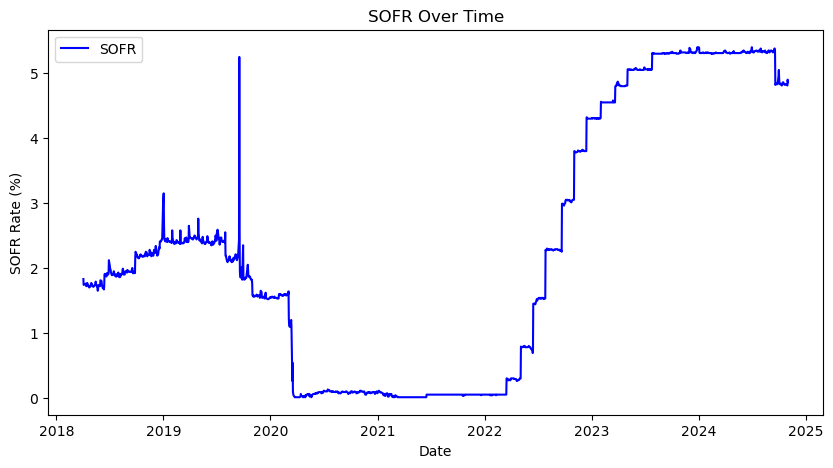

In [12]:
sofr['SOFR'] = pd.to_numeric(sofr['SOFR'], errors='coerce')
sofr = sofr.dropna()

plt.figure(figsize=(10, 5))
plt.plot(sofr.index, sofr['SOFR'], label='SOFR', color='blue')
plt.title("SOFR Over Time")
plt.xlabel("Date")
plt.ylabel("SOFR Rate (%)")
plt.legend()
plt.show()

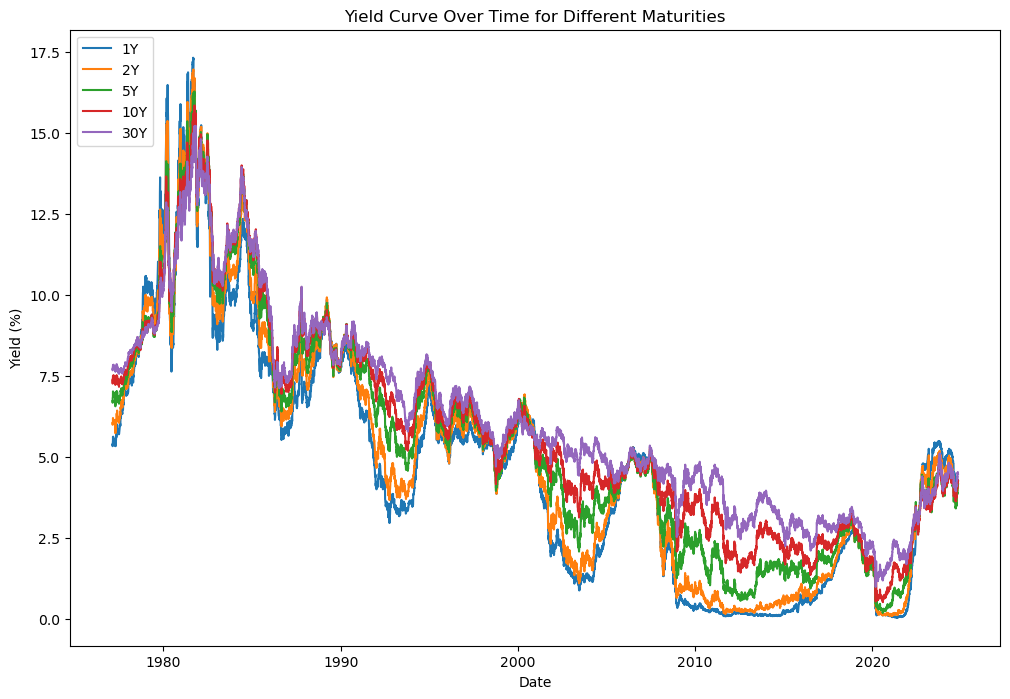

In [13]:
for col in yc.columns:
    yc[col] = pd.to_numeric(yc[col], errors='coerce')

yc = yc.interpolate(method='time').dropna()

plt.figure(figsize=(12, 8))
for col in yc.columns:
    plt.plot(yc.index, yc[col], label=col)
    
plt.title("Yield Curve Over Time for Different Maturities")
plt.xlabel("Date")
plt.ylabel("Yield (%)")
plt.legend(loc='upper left')
plt.show()

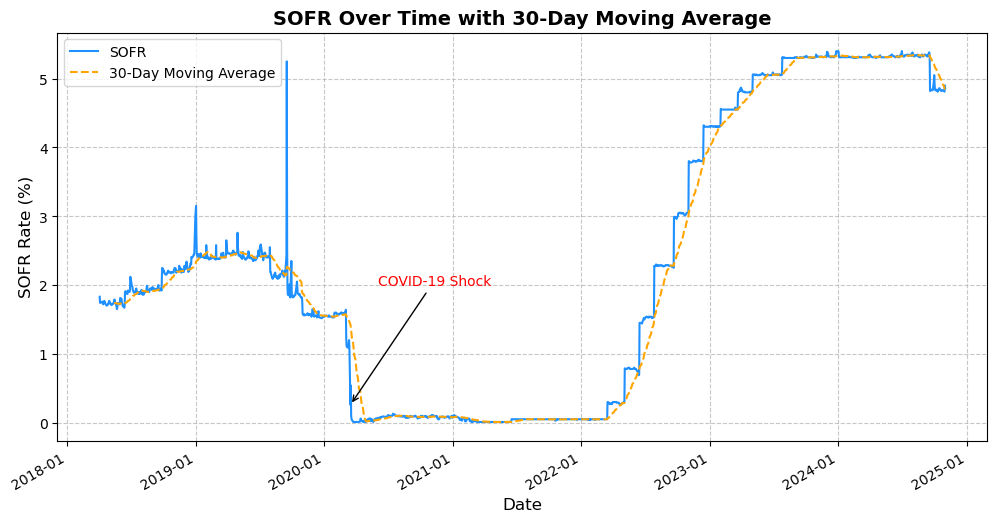

In [14]:
sofr['SOFR'] = pd.to_numeric(sofr['SOFR'], errors='coerce')
sofr = sofr.dropna() 

sofr['SOFR_MA'] = sofr['SOFR'].rolling(window=30).mean()

plt.figure(figsize=(12, 6))
plt.plot(sofr.index, sofr['SOFR'], label='SOFR', color='dodgerblue')
plt.plot(sofr.index, sofr['SOFR_MA'], label='30-Day Moving Average', color='orange', linestyle='--')
annot_date = datetime(2020, 3, 16)
plt.annotate('COVID-19 Shock', 
             xy=(annot_date, sofr.loc[annot_date, 'SOFR']), 
             xytext=(datetime(2020, 6, 1), 2.0),
             arrowprops=dict(facecolor='red', arrowstyle='->'), color='red')

plt.title("SOFR Over Time with 30-Day Moving Average", fontsize=14, fontweight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("SOFR Rate (%)", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gcf().autofmt_xdate()

plt.show()

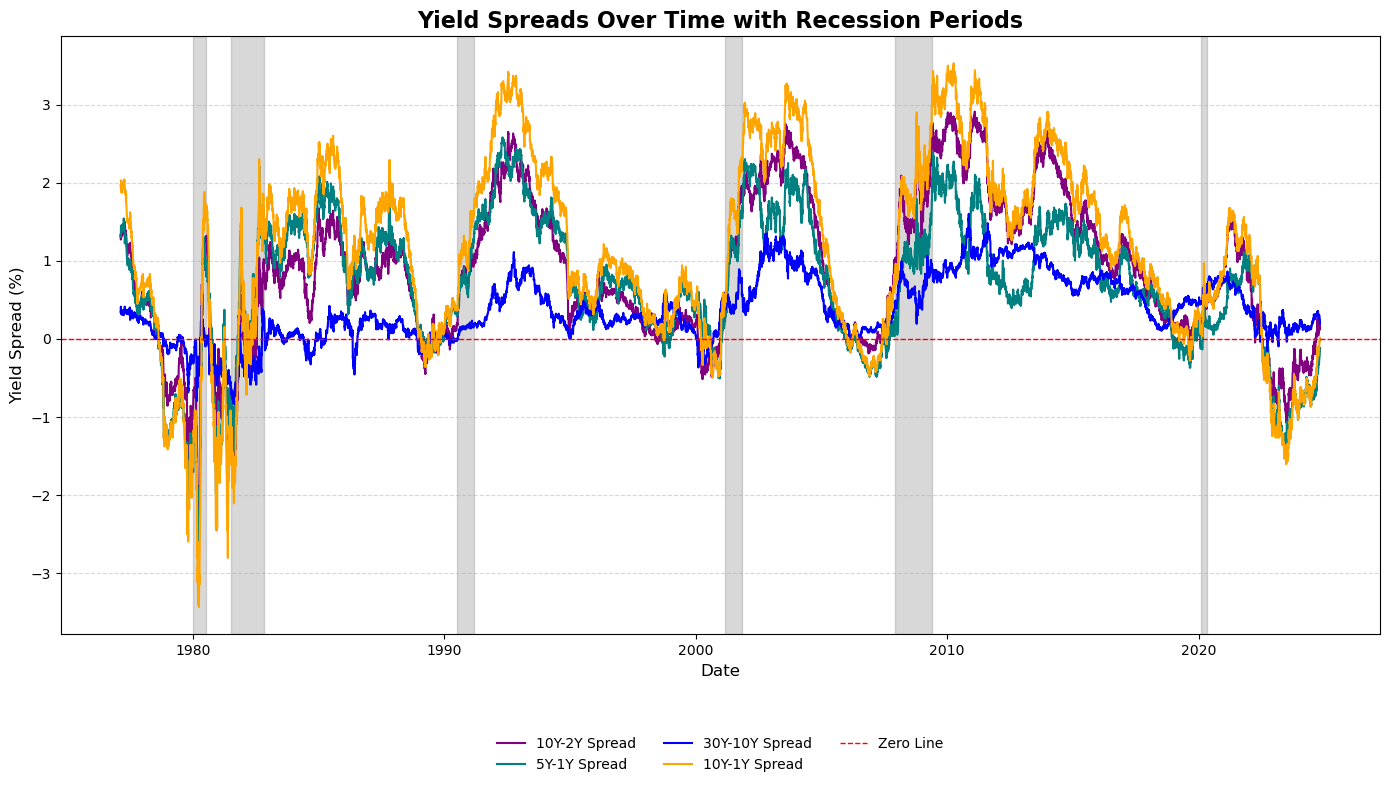

In [15]:
recession_periods = [
    ('1969-12-01', '1970-11-01'),
    ('1973-11-01', '1975-03-01'),
    ('1980-01-01', '1980-07-01'),
    ('1981-07-01', '1982-11-01'),
    ('1990-07-01', '1991-03-01'),
    ('2001-03-01', '2001-11-01'),
    ('2007-12-01', '2009-06-01'),
    ('2020-02-01', '2020-05-01') 
]

start_date = '1975-01-01'
filtered_yc = yc[yc.index >= start_date]
filtered_yc['10Y-2Y Spread'] = filtered_yc['10Y'] - filtered_yc['2Y']
filtered_yc['5Y-1Y Spread'] = filtered_yc['5Y'] - filtered_yc['1Y']
filtered_yc['30Y-10Y Spread'] = filtered_yc['30Y'] - filtered_yc['10Y']
filtered_yc['10Y-1Y Spread'] = filtered_yc['10Y'] - filtered_yc['1Y']

plt.figure(figsize=(14, 8))
plt.plot(filtered_yc.index, filtered_yc['10Y-2Y Spread'], color='purple', label='10Y-2Y Spread')
plt.plot(filtered_yc.index, filtered_yc['5Y-1Y Spread'], color='teal', label='5Y-1Y Spread')
plt.plot(filtered_yc.index, filtered_yc['30Y-10Y Spread'], color='blue', label='30Y-10Y Spread')
plt.plot(filtered_yc.index, filtered_yc['10Y-1Y Spread'], color='orange', label='10Y-1Y Spread')

plt.axhline(0, color='red', linestyle='--', label='Zero Line', linewidth=1)

for start, end in recession_periods:
    if start >= start_date: 
        plt.axvspan(start, end, color='gray', alpha=0.3)

plt.title("Yield Spreads Over Time with Recession Periods", fontsize=16, fontweight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Yield Spread (%)", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, fontsize=10, frameon=False)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# II: Construction of Forward Rate Curves

Forward Rate Curve:
               1Y-2Y     2Y-5Y    5Y-10Y   10Y-30Y
DATE                                              
1977-02-15  6.694009  7.175754  8.003838  7.870404
1977-02-16  6.643647  7.155755  7.983839  7.835380
1977-02-17  6.654136  7.125755  7.853263  7.875587
1977-02-18  6.744388  7.329690  8.003259  7.935427
1977-02-21  6.728915  7.339630  8.003176  7.942927


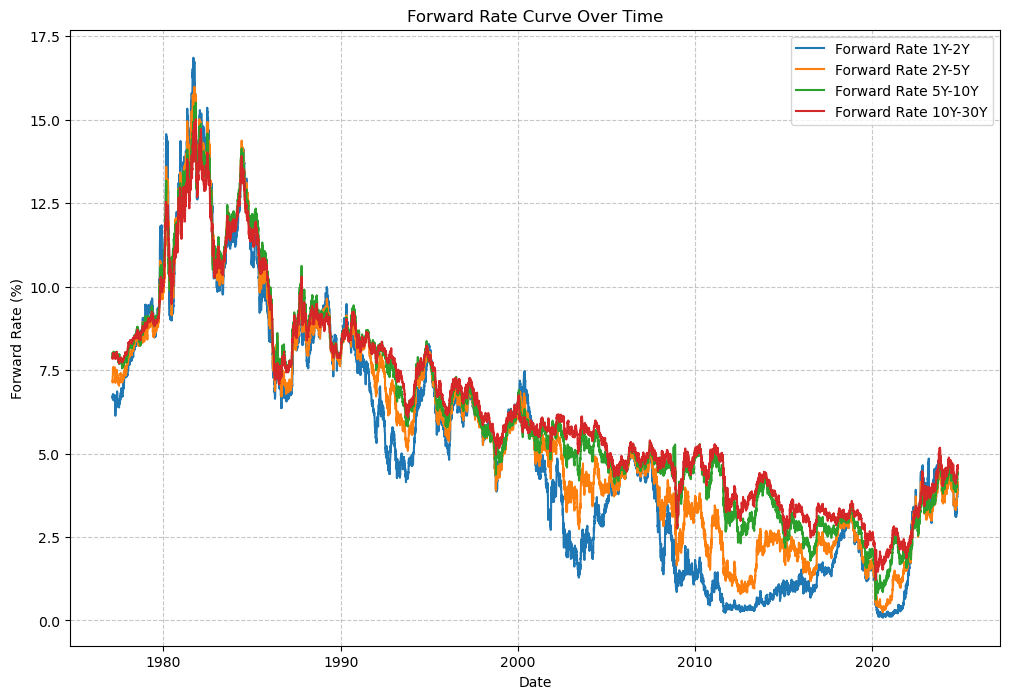

In [16]:
def calculate_forward_rate(yield_curve, t1, t2):
    r_t1 = yield_curve[f"{t1}Y"]
    r_t2 = yield_curve[f"{t2}Y"]
    
    forward_rate = ((1 + r_t2 / 100) ** t2 / (1 + r_t1 / 100) ** t1) ** (1 / (t2 - t1)) - 1
    return forward_rate * 100

forward_curve = pd.DataFrame(index=yc.index)
forward_curve['1Y-2Y'] = calculate_forward_rate(yc, 1, 2)
forward_curve['2Y-5Y'] = calculate_forward_rate(yc, 2, 5)
forward_curve['5Y-10Y'] = calculate_forward_rate(yc, 5, 10)
forward_curve['10Y-30Y'] = calculate_forward_rate(yc, 10, 30)

print("Forward Rate Curve:")
print(forward_curve.head())

plt.figure(figsize=(12, 8))
for column in forward_curve.columns:
    plt.plot(forward_curve.index, forward_curve[column], label=f"Forward Rate {column}")

plt.title("Forward Rate Curve Over Time")
plt.xlabel("Date")
plt.ylabel("Forward Rate (%)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [17]:
forward_curve.tail()

,1Y-2Y,2Y-5Y,5Y-10Y,10Y-30Y
DATE,,,,
2024-10-25,3.930311,4.043342,4.430311,4.640243
2024-10-28,3.960245,4.103334,4.450278,4.655225
2024-10-29,3.930311,4.110000,4.450278,4.640207
2024-10-30,4.020162,4.133334,4.440216,4.590144
2024-10-31,4.050116,4.143334,4.410162,4.565130


# III. Analysis of Yield Curve Movements using PCA

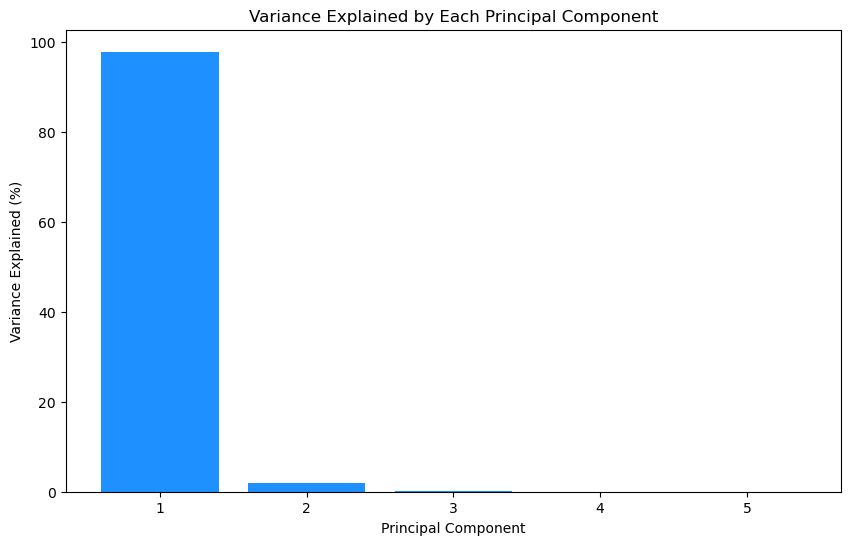

In [18]:
yield_data = yc[['1Y', '2Y', '5Y', '10Y', '30Y']]

scaler = StandardScaler()
yield_data_std = scaler.fit_transform(yield_data)

pca = PCA(n_components=5)
pca.fit(yield_data_std)
yield_pca = pca.transform(yield_data_std)
explained_variance = pca.explained_variance_ratio_

plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance * 100, color='dodgerblue')
plt.title("Variance Explained by Each Principal Component")
plt.xlabel("Principal Component")
plt.ylabel("Variance Explained (%)")
plt.show()

As expected, we see that most of the variance has been captured by the first PC. With the rest being captured by 2 and 3.

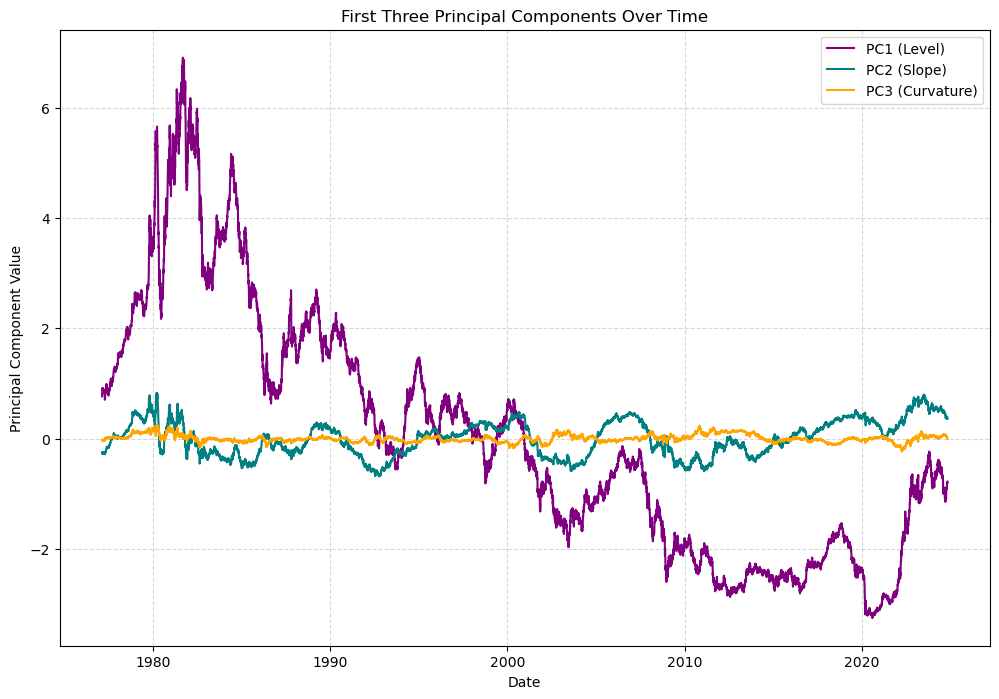

In [19]:
pca_df = pd.DataFrame(yield_pca, index=yield_data.index, columns=[f'PC{i+1}' for i in range(yield_pca.shape[1])])

plt.figure(figsize=(12, 8))
plt.plot(pca_df.index, pca_df['PC1'], label='PC1 (Level)', color='purple')
plt.plot(pca_df.index, pca_df['PC2'], label='PC2 (Slope)', color='teal')
plt.plot(pca_df.index, pca_df['PC3'], label='PC3 (Curvature)', color='orange')
plt.title("First Three Principal Components Over Time")
plt.xlabel("Date")
plt.ylabel("Principal Component Value")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

The principal components are used to calibrate the volatility structure of the HJM model. This ensures that the stochastic simulation of forward rates reflects historical yield curve dynamics. Each PC is associated with a factor in the HJM model, which influences how forward rates evolve over time.

## i. Incorporating PCA factors for Volatility Calcualtions

In [20]:
# eigenvectors: factor loadings
# eigenvalues: explained variance
def calculate_volatility(t, T_index, eigenvectors, eigenvalues, n_factors=3, scaling_factor=10):
    volatility = 0
    for i in range(min(n_factors, len(eigenvalues))):
        eigenvalue_rescaled = np.sqrt(eigenvalues[i]) / scaling_factor
        term = eigenvectors[i, T_index] * eigenvalue_rescaled * np.exp(-0.01 * t)
        volatility += term
        # Debug O/P:
        # print(f"Factor {i + 1}: Eigenvalue = {eigenvalues[i]:.6f}, "
        #       f"Rescaled Eigenvalue = {eigenvalue_rescaled:.6f}, "
        #       f"Eigenvector = {eigenvectors[i, T_index]:.6f}, Term = {term:.6f}")
    return abs(volatility)

# IV: Stochastic Modeling with the HJM Framework

## i. Monte Carlo Simulation

In [21]:
print("Select a random number generation method for the diffusion component:")
print("1: Standard Normal Distribution")
print("2: Uniform Distribution")
print("3: Sobol Sequence")
print("4: Halton Sequence")
print("5: Latin Hypercube Sequence")
user_choice = int(input("Enter your choice (1/2/3/4/5): "))
rng_methods = {
    1: "normal",
    2: "uniform",
    3: "sobol",
    4: "halton",
    5: "lhs",
}
rng_method = rng_methods.get(user_choice, "normal")
print(f"Using RNG Method: {rng_method}")

Select a random number generation method for the diffusion component:
1: Standard Normal Distribution
2: Uniform Distribution
3: Sobol Sequence
4: Halton Sequence
5: Latin Hypercube Sequence
Using RNG Method: normal


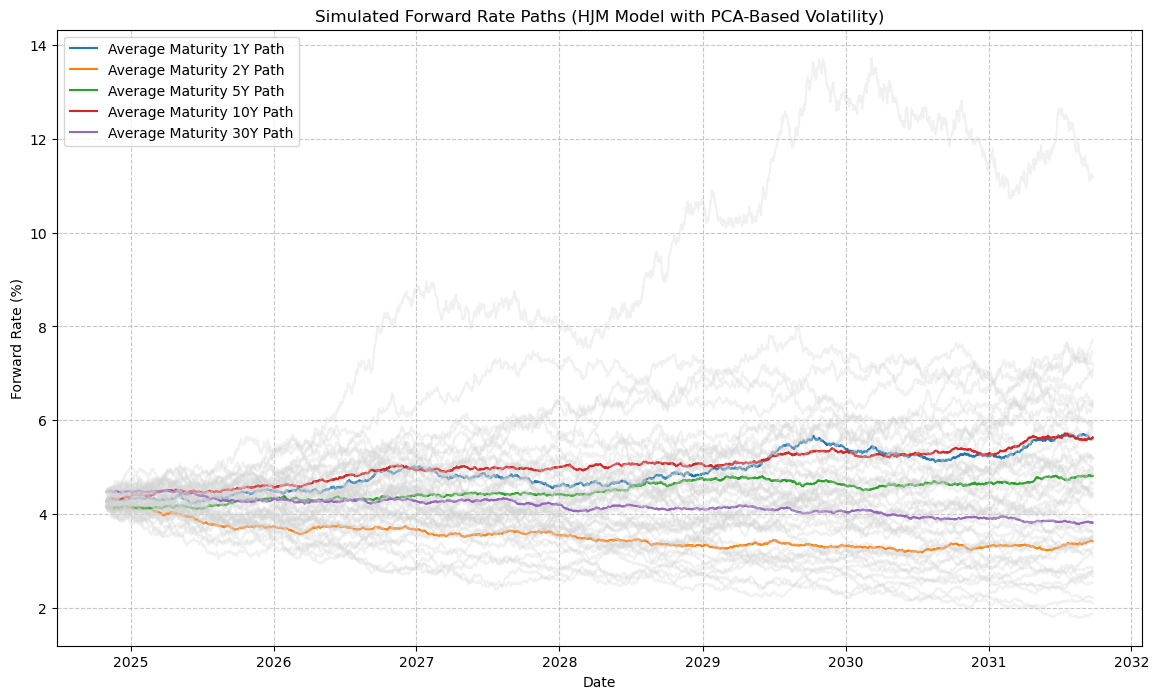

In [ ]:
available_maturities = ['1Y', '2Y', '5Y', '10Y', '30Y']
n_steps = 252  * 10
n_simulations = 10
dt = 1 / 252
initial_forward_rates = yc[available_maturities].iloc[-1].values
n_maturities = len(initial_forward_rates)

simulated_forward_rates = np.zeros((n_steps, n_maturities, n_simulations))
simulated_forward_rates[0, :, :] = initial_forward_rates[:, np.newaxis]

for i in range(1, n_steps):
    dW = rng.generate_random_numbers(rng_method, (n_maturities, n_simulations), dt=dt) # correct RNG
    for j in range(n_maturities):
        volatility = calculate_volatility(i * dt, j, pca.components_, pca.explained_variance_)
        drift = 0 
        diffusion = volatility * dW[j, :]
        simulated_forward_rates[i, j, :] = simulated_forward_rates[i - 1, j, :] * np.exp(drift * dt + diffusion)

dates = pd.date_range(start=yc.index[-1], periods=n_steps, freq='D')
simulated_paths = {f'Maturity {m}Y': pd.DataFrame(simulated_forward_rates[:, j, :], index=dates) for j, m in enumerate([1, 2, 5, 10, 30])}

plt.figure(figsize=(14, 8))
for maturity, paths in simulated_paths.items():
    plt.plot(paths.index, paths.mean(axis=1), label=f"Average {maturity} Path")
    for path in paths.columns:
        plt.plot(paths.index, paths[path], color='lightgray', alpha=0.3)

plt.title("Simulated Forward Rate Paths (HJM Model with PCA-Based Volatility)")
plt.xlabel("Date")
plt.ylabel("Forward Rate (%)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [ ]:
# DEBUGGING
print("Initial Forward Rates (from Yield Curve):", initial_forward_rates)

for j in range(n_maturities):
    print(f"Volatility for Maturity {j+1}Y at Step 1: {calculate_volatility(dt, j, pca.components_, pca.explained_variance_)}")

for i in range(1, n_steps):
    dW = rng.generate_random_numbers("normal", (n_maturities, n_simulations), dt=dt)
    for j in range(n_maturities):
        volatility = calculate_volatility(i * dt, j, pca.components_, pca.explained_variance_)
        drift = 0  # Drift term is set to zero in HJM
        diffusion = volatility * dW[j, :]
        print(f"Step {i}, Maturity {j+1}Y: Drift = {drift}, Diffusion = {np.mean(diffusion):.6f}")
    break

Initial Forward Rates (from Yield Curve): [4.27 4.16 4.15 4.28 4.47]
Volatility for Maturity 1Y at Step 1: 0.12124747081113599
Volatility for Maturity 2Y at Step 1: 0.10945538597405328
Volatility for Maturity 3Y at Step 1: 0.09434825514360755
Volatility for Maturity 4Y at Step 1: 0.08732657934608619
Volatility for Maturity 5Y at Step 1: 0.08236724979434282
Step 1, Maturity 1Y: Drift = 0, Diffusion = 0.001315
Step 1, Maturity 2Y: Drift = 0, Diffusion = -0.000550
Step 1, Maturity 3Y: Drift = 0, Diffusion = -0.002045
Step 1, Maturity 4Y: Drift = 0, Diffusion = 0.002738
Step 1, Maturity 5Y: Drift = 0, Diffusion = 0.000625


In [24]:
print("Simulated Forward Rates Shape:", simulated_forward_rates.shape)

Simulated Forward Rates Shape: (2520, 5, 10)


The standard deviation values are relatively low, suggesting stability in the volatility estimates over the simulation horizon.

## ii. Validation of RNG Schemes

/Users/atheeshkrishnan/anaconda3/lib/python3.11/site-packages/scipy/stats/_qmc.py:804: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


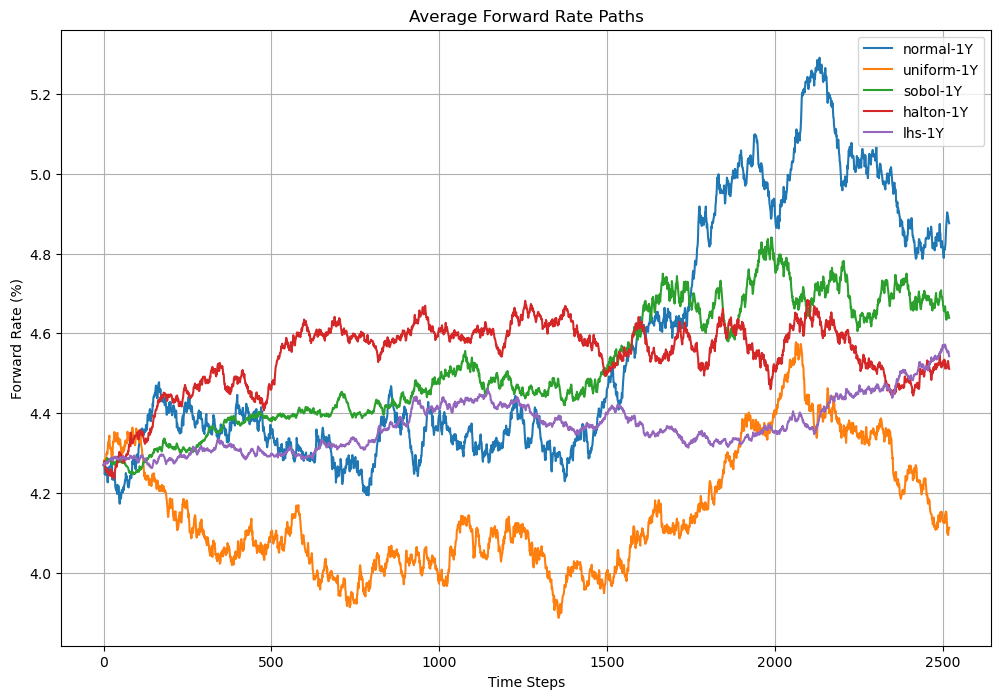

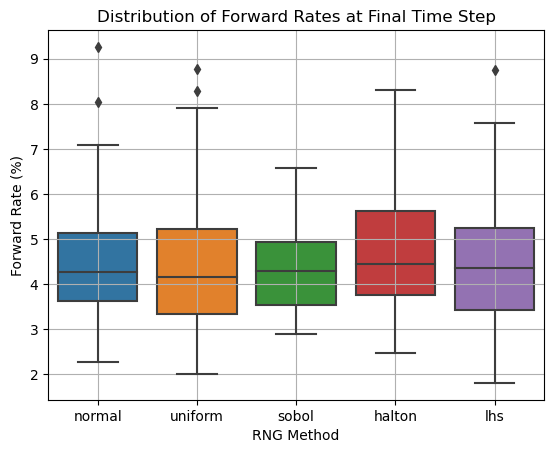

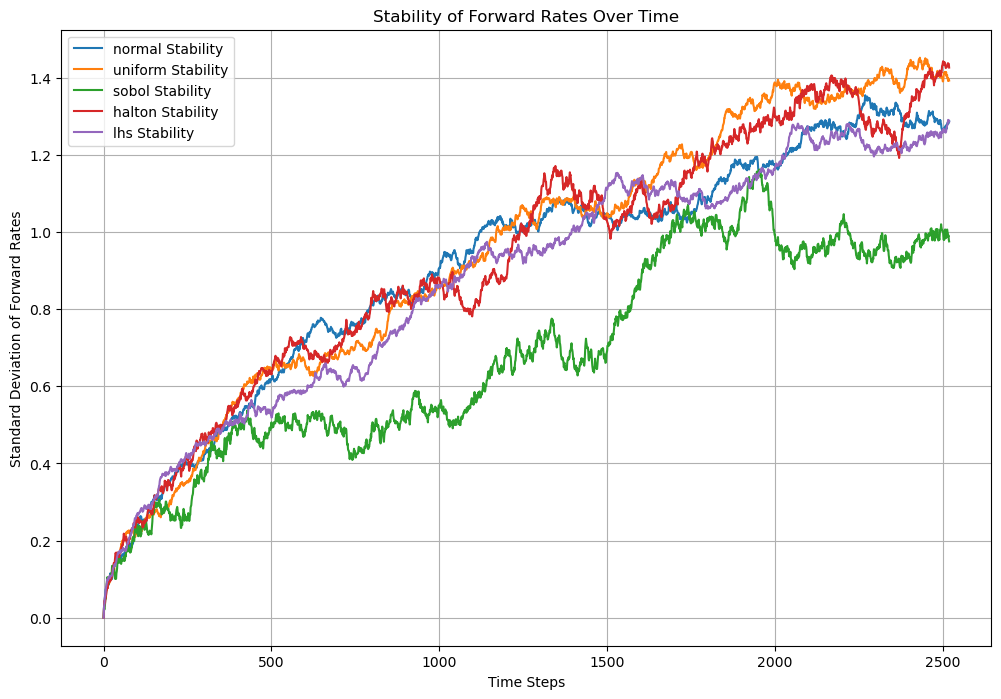

         Mean (Final Step)  Std Dev (Final Step)  Min (Final Step)  \
normal            4.530133              1.287015          2.261621   
uniform           4.381705              1.392904          2.012615   
sobol             4.383944              0.975744          2.887052   
halton            4.654217              1.426469          2.461665   
lhs               4.457076              1.286788          1.806826   

         Max (Final Step)  Computation Time (s)  
normal           9.262690              0.126222  
uniform          8.766541              0.318885  
sobol            6.575204              0.707604  
halton           8.315984              0.963018  
lhs              8.751190              0.536087  


In [ ]:
rng_methods = ["normal", "uniform", "sobol", "halton", "lhs"]
forward_rate_results = {}

for method in rng_methods:
    start_time = time.time()
    simulated_forward_rates = np.zeros((n_steps, n_maturities, n_simulations))
    simulated_forward_rates[0, :, :] = initial_forward_rates[:, np.newaxis]

    for i in range(1, n_steps):
        dW = rng.generate_random_numbers(method, (n_maturities, n_simulations), dt=dt)
        for j in range(n_maturities):
            volatility = calculate_volatility(i * dt, j, pca.components_, pca.explained_variance_)
            diffusion = volatility * dW[j, :]
            simulated_forward_rates[i, j, :] = simulated_forward_rates[i - 1, j, :] * np.exp(diffusion)

    end_time = time.time()
    forward_rate_results[method] = {
        "rates": simulated_forward_rates,
        "time": end_time - start_time
    }

metrics = {}
for method, results in forward_rate_results.items():
    rates = results["rates"]
    mean_rates = np.mean(rates, axis=2)
    std_rates = np.std(rates, axis=2)
    min_rates = np.min(rates, axis=2)
    max_rates = np.max(rates, axis=2)
    metrics[method] = {
        "mean": mean_rates,
        "std": std_rates,
        "min": min_rates,
        "max": max_rates,
        "time": results["time"]
    }

plt.figure(figsize=(12, 8))
for method in rng_methods:
    avg_path = np.mean(forward_rate_results[method]["rates"], axis=2)
    plt.plot(avg_path[:, 0], label=f"{method}-1Y")
plt.title("Average Forward Rate Paths")
plt.xlabel("Time Steps")
plt.ylabel("Forward Rate (%)")
plt.legend()
plt.grid()
plt.show()

# BOXPLOTS
final_step_rates = {method: results["rates"][-1, :, :].flatten() for method, results in forward_rate_results.items()}
df_boxplot = pd.DataFrame(final_step_rates)
sns.boxplot(data=df_boxplot)
plt.title("Distribution of Forward Rates at Final Time Step")
plt.ylabel("Forward Rate (%)")
plt.xlabel("RNG Method")
plt.grid()
plt.show()

# STABILITY
plt.figure(figsize=(12, 8))
for method in rng_methods:
    std_over_time = np.std(forward_rate_results[method]["rates"], axis=2)
    plt.plot(np.mean(std_over_time, axis=1), label=f"{method} Stability")
plt.title("Stability of Forward Rates Over Time")
plt.xlabel("Time Steps")
plt.ylabel("Standard Deviation of Forward Rates")
plt.legend()
plt.grid()
plt.show()

summary_table = pd.DataFrame({method: {"Mean (Final Step)": np.mean(metrics[method]["mean"][-1]),
                                       "Std Dev (Final Step)": np.mean(metrics[method]["std"][-1]),
                                       "Min (Final Step)": np.min(metrics[method]["min"][-1]),
                                       "Max (Final Step)": np.max(metrics[method]["max"][-1]),
                                       "Computation Time (s)": metrics[method]["time"]}
                               for method in rng_methods}).T
print(summary_table)

# V. Pricing IR Derivatives

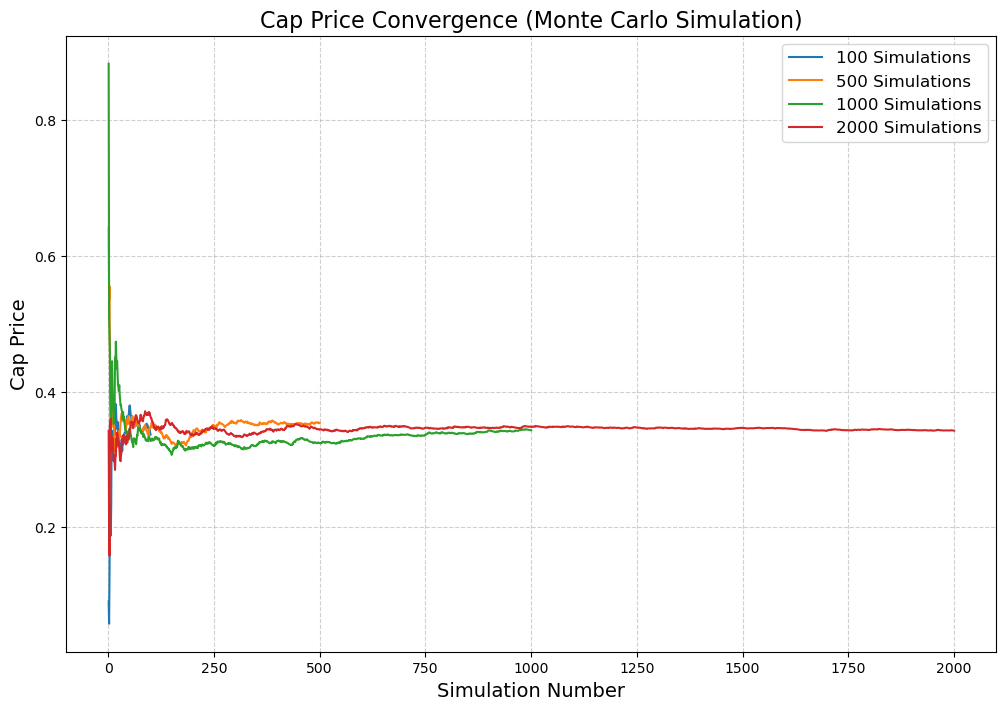

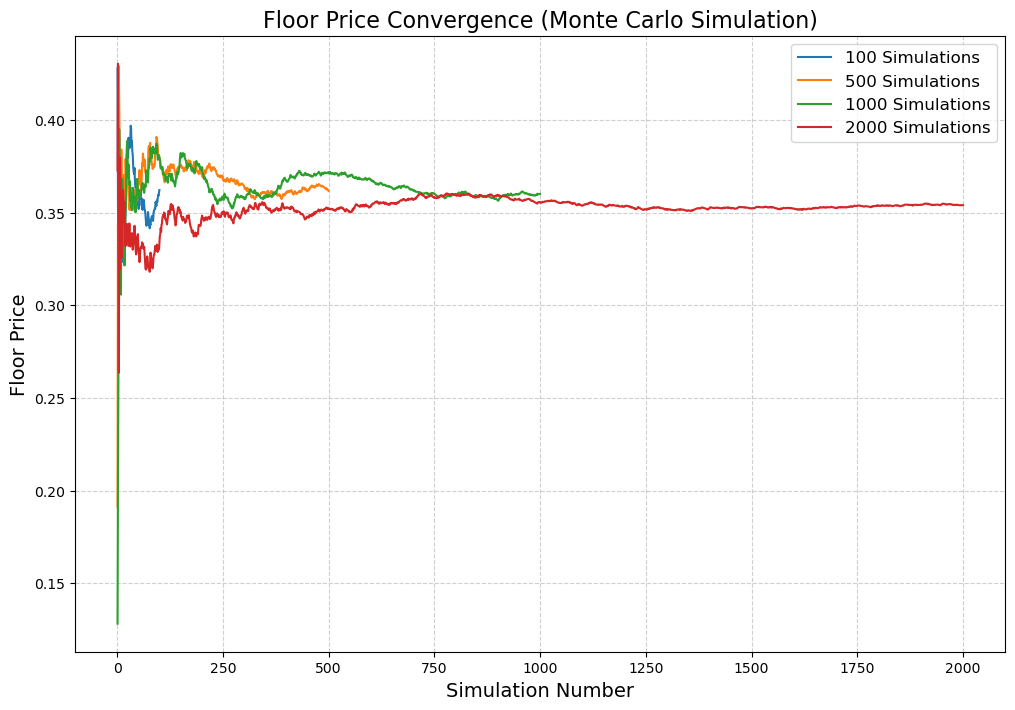

Cap Prices Convergence Results:
100 Simulations: [0.3527169058942296, 0.34999649783055814, 0.3504825647424382, 0.3467540268196463, 0.34517580462598446, 0.34524719446884466, 0.34225177360532444, 0.34270777691167564, 0.3397529086239972, 0.3366810082660401]
500 Simulations: [0.35475038367196793, 0.3546912413347851, 0.35442828450519315, 0.3545176984933804, 0.3548163116910102, 0.3542331241146719, 0.35367954768935606, 0.35445468227866517, 0.35416221856016633, 0.3538047867064993]
1000 Simulations: [0.3440188431306247, 0.3440320437449973, 0.3438561298222178, 0.3435101981020747, 0.34345782029038613, 0.3434401157160241, 0.34348302485121307, 0.3433213882920737, 0.34313656078830573, 0.3431674870518537]
2000 Simulations: [0.34315986970517903, 0.34309830041628037, 0.34305864945066206, 0.34308759273939665, 0.34301662739825184, 0.3429160256402637, 0.3428389455548224, 0.3426901634728634, 0.34266921942386963, 0.34253618258247304]

Floor Prices Convergence Results:
100 Simulations: [0.3557282563140868, 0

In [ ]:
sofr_discount_factors = sofr['Discount_Factor']
expiry = 5
n_simulations_list = [100, 500, 1000, 2000] 
dt = 1 / 252
expiry_index = int(expiry / dt) - 1
strike = simulated_forward_rates[expiry_index, :, :].mean() + 0.005

def price_cap(simulated_forward_rates, strike, expiry_index, sofr_discount_factors):
    forward_rates = simulated_forward_rates[expiry_index, :, :]
    payoffs = np.maximum(forward_rates - strike, 0).mean(axis=0)
    discount_factor = sofr_discount_factors.iloc[expiry_index]
    cap_price = payoffs * discount_factor
    return cap_price.mean()

def price_floor(simulated_forward_rates, strike, expiry_index, sofr_discount_factors):
    forward_rates = simulated_forward_rates[expiry_index, :, :]
    payoffs = np.maximum(strike - forward_rates, 0)
    average_payoffs = payoffs.mean(axis=0)
    discount_factor = sofr_discount_factors.iloc[expiry_index]
    floor_price = average_payoffs * discount_factor
    return floor_price.mean()

cap_convergence = {n_sim: [] for n_sim in n_simulations_list}
floor_convergence = {n_sim: [] for n_sim in n_simulations_list}
final_prices = {"Caps": {}, "Floors": {}} 

for n_simulations in n_simulations_list:
    simulated_forward_rates = np.zeros((expiry_index + 1, 5, n_simulations))
    simulated_forward_rates[0, :, :] = initial_forward_rates[:, np.newaxis]
    for t in range(1, expiry_index + 1):
        dW = rng.generate_random_numbers(rng_method, (5, n_simulations), dt=dt)
        for j in range(5):
            volatility = calculate_volatility(t * dt, j, pca.components_, pca.explained_variance_)
            diffusion = volatility * dW[j, :]
            simulated_forward_rates[t, j, :] = simulated_forward_rates[t - 1, j, :] * np.exp(diffusion)

    for sim in range(1, n_simulations + 1):
        cap_convergence[n_simulations].append(
            price_cap(simulated_forward_rates[:, :, :sim], strike, expiry_index, sofr_discount_factors)
        )
        floor_convergence[n_simulations].append(
            price_floor(simulated_forward_rates[:, :, :sim], strike, expiry_index, sofr_discount_factors)
        )

    final_prices["Caps"][n_simulations] = cap_convergence[n_simulations][-1]
    final_prices["Floors"][n_simulations] = floor_convergence[n_simulations][-1]

# CAP CONVERGENCE
plt.figure(figsize=(12, 8))
for n_simulations in n_simulations_list:
    plt.plot(range(1, n_simulations + 1), cap_convergence[n_simulations], label=f"{n_simulations} Simulations")
plt.title("Cap Price Convergence (Monte Carlo Simulation)", fontsize=16)
plt.xlabel("Simulation Number", fontsize=14)
plt.ylabel("Cap Price", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(fontsize=12)
plt.show()

# FLOOR CONVERGENCEC
plt.figure(figsize=(12, 8))
for n_simulations in n_simulations_list:
    plt.plot(range(1, n_simulations + 1), floor_convergence[n_simulations], label=f"{n_simulations} Simulations")
plt.title("Floor Price Convergence (Monte Carlo Simulation)", fontsize=16)
plt.xlabel("Simulation Number", fontsize=14)
plt.ylabel("Floor Price", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(fontsize=12)
plt.show()

print("Cap Prices Convergence Results:")
for n_simulations in n_simulations_list:
    print(f"{n_simulations} Simulations: {cap_convergence[n_simulations][-10:]}")

print("\nFloor Prices Convergence Results:")
for n_simulations in n_simulations_list:
    print(f"{n_simulations} Simulations: {floor_convergence[n_simulations][-10:]}")

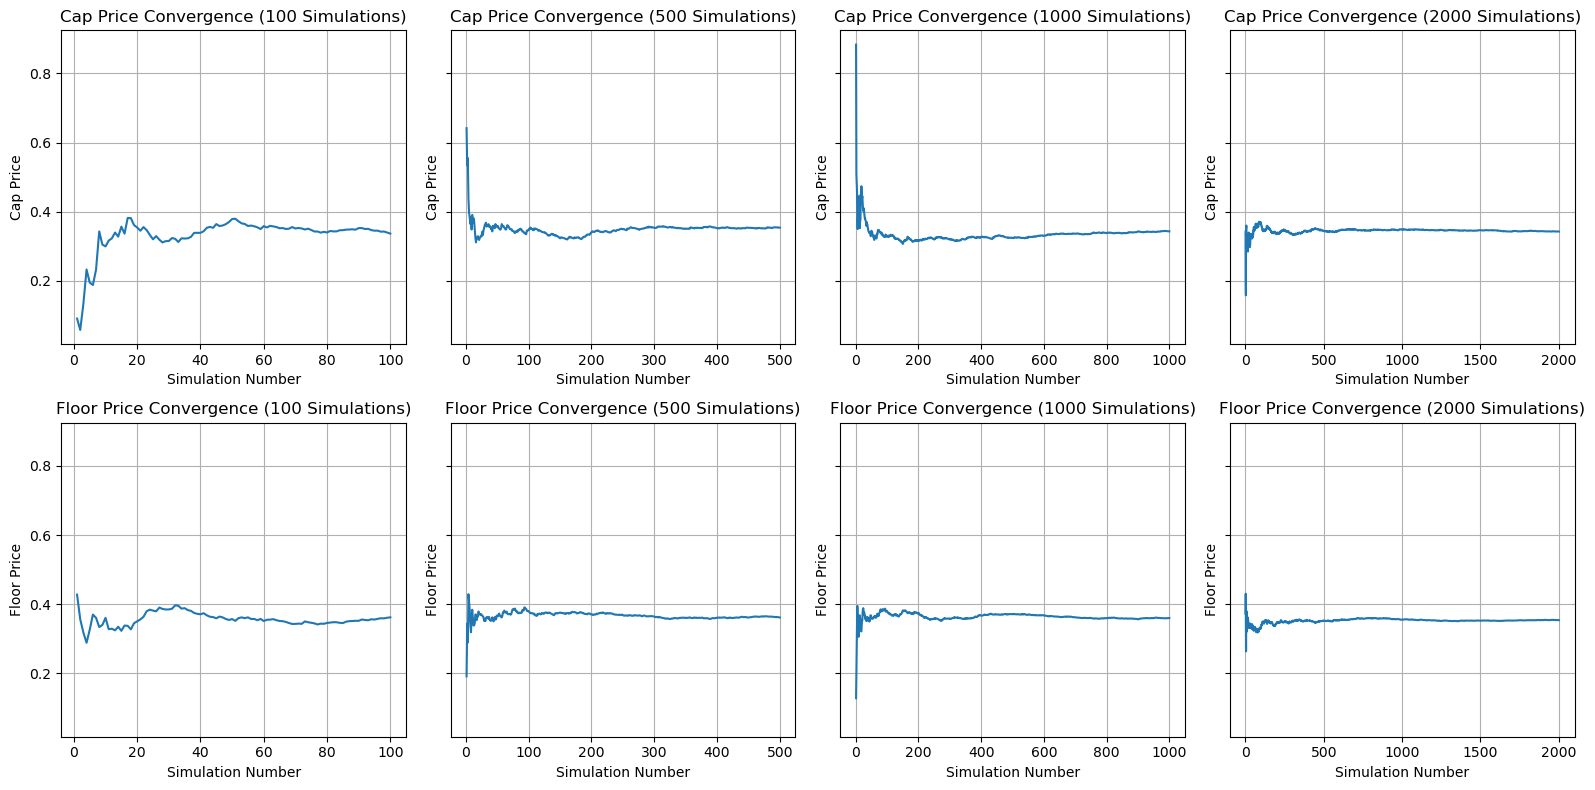


Final Monte Carlo Prices:

Cap Prices Convergence Results:
   Number of Simulations  Cap Price
0                    100   0.336681
1                    500   0.353805
2                   1000   0.343167
3                   2000   0.342536

Floor Prices Convergence Results:
   Number of Simulations  Floor Price
0                    100     0.362078
1                    500     0.361650
2                   1000     0.360052
3                   2000     0.353924


In [ ]:
fig, axs = plt.subplots(2, len(n_simulations_list), figsize=(16, 8), sharey=True)
for i, n_simulations in enumerate(n_simulations_list):
    axs[0, i].plot(range(1, n_simulations + 1), cap_convergence[n_simulations], label="Cap Convergence")
    axs[0, i].set_title(f"Cap Price Convergence ({n_simulations} Simulations)")
    axs[0, i].set_xlabel("Simulation Number")
    axs[0, i].set_ylabel("Cap Price")
    axs[0, i].grid()

    axs[1, i].plot(range(1, n_simulations + 1), floor_convergence[n_simulations], label="Floor Convergence")
    axs[1, i].set_title(f"Floor Price Convergence ({n_simulations} Simulations)")
    axs[1, i].set_xlabel("Simulation Number")
    axs[1, i].set_ylabel("Floor Price")
    axs[1, i].grid()

plt.tight_layout()
plt.show()

print("\nFinal Monte Carlo Prices:")
cap_df = pd.DataFrame.from_dict(final_prices["Caps"], orient="index", columns=["Cap Price"]).reset_index()
cap_df.rename(columns={"index": "Number of Simulations"}, inplace=True)
floor_df = pd.DataFrame.from_dict(final_prices["Floors"], orient="index", columns=["Floor Price"]).reset_index()
floor_df.rename(columns={"index": "Number of Simulations"}, inplace=True)

print("\nCap Prices Convergence Results:")
print(cap_df)

print("\nFloor Prices Convergence Results:")
print(floor_df)

# VI. Variance Reduction

In [ ]:
def standard_mc(simulated_forward_rates, strike, expiry_index, sofr_discount_factors):
    forward_rates = simulated_forward_rates[expiry_index, :, :]
    payoffs = np.maximum(forward_rates - strike, 0).mean(axis=0)
    discount_factor = sofr_discount_factors.iloc[expiry_index]
    cap_price = payoffs * discount_factor
    return cap_price.mean()

In [ ]:
def antithetic_variates(simulated_forward_rates, strike, expiry_index, sofr_discount_factors):
    forward_rates = simulated_forward_rates[expiry_index, :, :]
    antithetic_rates = -simulated_forward_rates[expiry_index, :, :]
    payoffs = np.maximum(forward_rates - strike, 0)
    antithetic_payoffs = np.maximum(antithetic_rates - strike, 0)
    combined_payoffs = (payoffs + antithetic_payoffs) / 2 
    discount_factor = sofr_discount_factors.iloc[expiry_index]
    return (combined_payoffs.mean() * discount_factor)

In [ ]:
def control_variates(simulated_forward_rates, strike, expiry_index, sofr_discount_factors, analytical_price):
    forward_rates = simulated_forward_rates[expiry_index, :, :]
    payoffs = np.maximum(forward_rates - strike, 0).mean(axis=0)
    discount_factor = sofr_discount_factors.iloc[expiry_index]
    estimated_price = payoffs * discount_factor
    if np.isscalar(analytical_price):
        adjustment = analytical_price - np.mean(estimated_price)
    else:
        raise ValueError("Analytical price should be a scalar value.") 
    return np.mean(estimated_price) + adjustment

In [39]:
volatility_fn = calculate_volatility
def generate_simulated_paths(n_simulations, expiry_index):
    simulated_forward_rates = np.zeros((expiry_index + 1, n_maturities, n_simulations))
    simulated_forward_rates[0, :, :] = initial_forward_rates[:, np.newaxis]  # Initial rates

    for t in range(1, expiry_index + 1):
        dW = rng.generate_random_numbers(rng_method, (n_maturities, n_simulations), dt=dt)
        for j in range(n_maturities):
            volatility = volatility_fn(t * dt, j, pca.components_, pca.explained_variance_)
            drift = 0
            diffusion = volatility * dW[j, :]
            simulated_forward_rates[t, j, :] = simulated_forward_rates[t - 1, j, :] * np.exp(drift * dt + diffusion)

    return simulated_forward_rates

/var/folders/xg/dhj8tpr14lqgyb0stf1z1sm40000gn/T/ipykernel_77717/497001900.py:34: RuntimeWarning: invalid value encountered in scalar divide
  control_adjustment = -cov / np.var(control_variate)


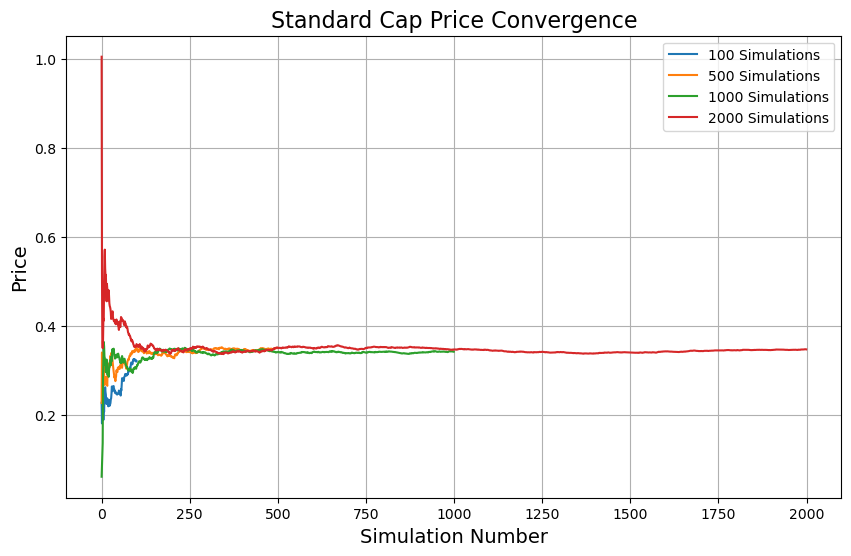

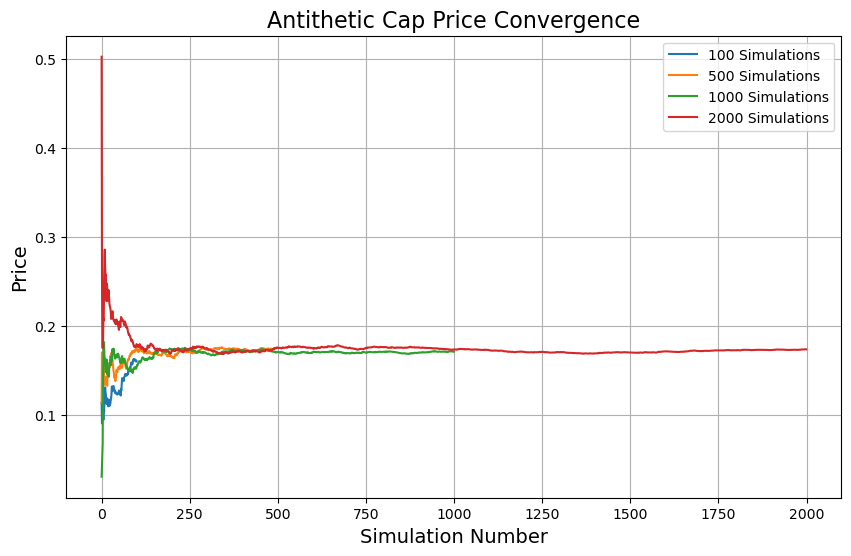

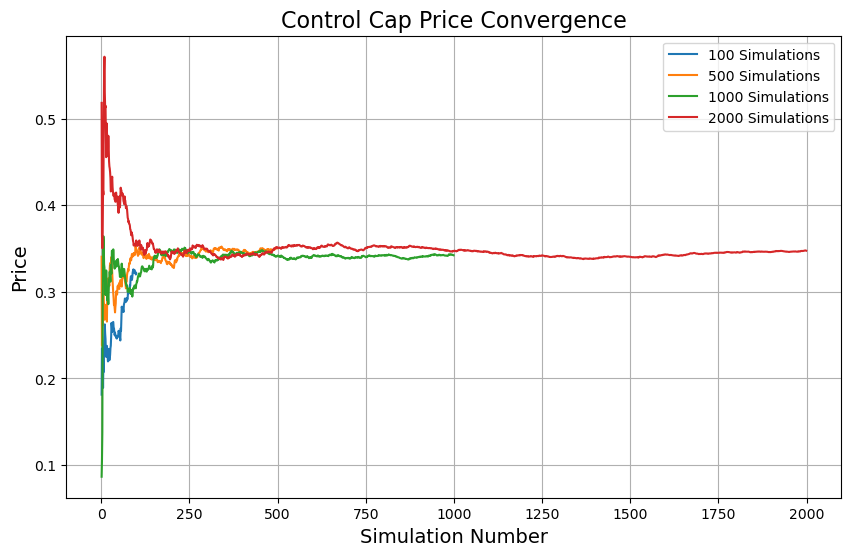

In [ ]:
sofr_discount_factors = sofr['Discount_Factor']
expiry = 5
n_simulations_list = [100, 500, 1000, 2000]
dt = 1 / 252
expiry_index = int(expiry / dt) - 1
strike = simulated_forward_rates[expiry_index, :, :].mean() + 0.005

def price_cap(simulated_forward_rates, strike, expiry_index, sofr_discount_factors):
    forward_rates = simulated_forward_rates[expiry_index, :, :]
    payoffs = np.maximum(forward_rates - strike, 0).mean(axis=0)
    discount_factor = sofr_discount_factors.iloc[expiry_index]
    cap_price = payoffs * discount_factor
    return cap_price.mean()

# Antithetic
def price_antithetic(simulated_forward_rates, strike, expiry_index, sofr_discount_factors):
    forward_rates = simulated_forward_rates[expiry_index, :, :]
    antithetic_rates = 1 - simulated_forward_rates[expiry_index, :, :]
    forward_rates_combined = np.concatenate((forward_rates, antithetic_rates), axis=1)
    payoffs = np.maximum(forward_rates_combined - strike, 0).mean(axis=0)
    discount_factor = sofr_discount_factors.iloc[expiry_index]
    cap_price = payoffs * discount_factor
    return cap_price.mean()

# Control
def price_control_variates(simulated_forward_rates, strike, expiry_index, sofr_discount_factors):
    forward_rates = simulated_forward_rates[expiry_index, :, :]
    payoffs = np.maximum(forward_rates - strike, 0)
    discount_factor = sofr_discount_factors.iloc[expiry_index]
    mc_price = payoffs.mean(axis=0) * discount_factor
    control_variate = forward_rates.mean(axis=0)  
    analytical_control_price = control_variate.mean()
    cov = np.cov(mc_price, control_variate, bias=True)[0, 1]
    control_adjustment = -cov / np.var(control_variate)
    adjusted_price = mc_price + control_adjustment * (control_variate - analytical_control_price)
    return adjusted_price.mean()

convergence_results = {"Standard": {}, "Antithetic": {}, "Control": {}}
for n_simulations in n_simulations_list:
    simulated_forward_rates = generate_simulated_paths(n_simulations, expiry_index)

    for sim in range(1, n_simulations + 1):
        standard_price = price_cap(simulated_forward_rates[:, :, :sim], strike, expiry_index, sofr_discount_factors)
        convergence_results["Standard"].setdefault(n_simulations, []).append(standard_price)

        antithetic_price = price_antithetic(simulated_forward_rates[:, :, :sim], strike, expiry_index, sofr_discount_factors)
        convergence_results["Antithetic"].setdefault(n_simulations, []).append(antithetic_price)

        control_price = price_control_variates(simulated_forward_rates[:, :, :sim], strike, expiry_index, sofr_discount_factors)
        convergence_results["Control"].setdefault(n_simulations, []).append(control_price)

methods = ["Standard", "Antithetic", "Control"]
for method in methods:
    plt.figure(figsize=(10, 6))
    for n_simulations in n_simulations_list:
        plt.plot(convergence_results[method][n_simulations], label=f"{n_simulations} Simulations")
    plt.title(f"{method} Cap Price Convergence", fontsize=16)
    plt.xlabel("Simulation Number", fontsize=14)
    plt.ylabel("Price", fontsize=14)
    plt.legend()
    plt.grid(True)
    plt.show()

In [41]:
reference_price = convergence_results["Standard"][2000][-1]

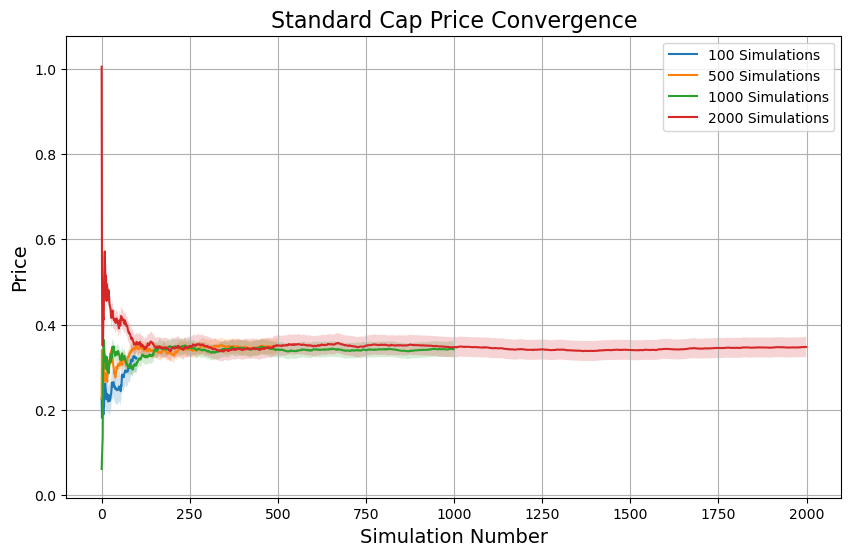

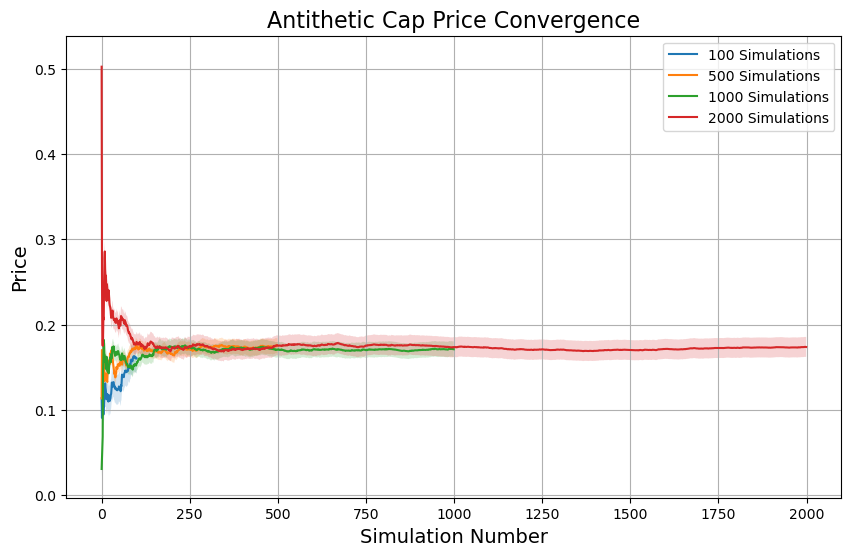

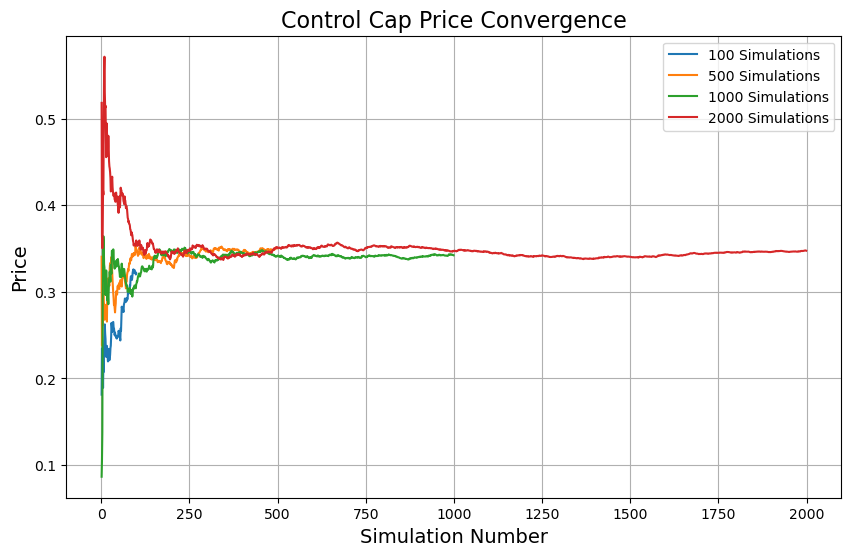

In [42]:
for method in methods:
    plt.figure(figsize=(10, 6))
    for n_simulations in n_simulations_list:
        prices = np.array(convergence_results[method][n_simulations])
        std_dev = np.std(prices)
        plt.plot(prices, label=f"{n_simulations} Simulations")
        plt.fill_between(range(len(prices)), prices - std_dev, prices + std_dev, alpha=0.2)
    plt.title(f"{method} Cap Price Convergence", fontsize=16)
    plt.xlabel("Simulation Number", fontsize=14)
    plt.ylabel("Price", fontsize=14)
    plt.legend()
    plt.grid(True)
    plt.show()